In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras import regularizers
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [2]:
labels = os.listdir("C:/Users/Safa/Desktop/PFE_2023/sleep_detection/train")

In [3]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

# visualize random 1 image¶


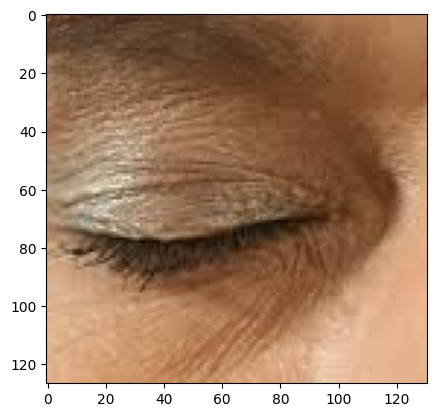

In [4]:
#closeEye
import matplotlib.pyplot as plt
plt.imshow(plt.imread("C:/Users/Safa/Desktop/PFE_2023/sleep_detection/train/Closed/_10.jpg"))

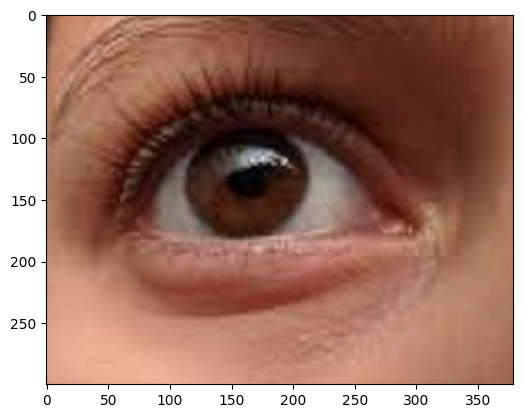

In [5]:
#openEye
import matplotlib.pyplot as plt
plt.imshow(plt.imread("C:/Users/Safa/Desktop/PFE_2023/sleep_detection/train/Open/_100.jpg"))

# visualize yawn image

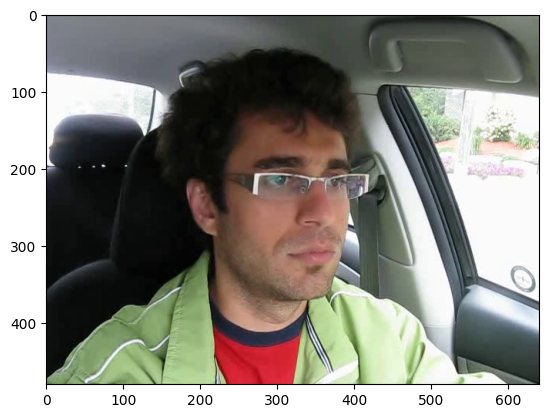

In [6]:
#no yawn
plt.imshow(plt.imread("C:/Users/Safa/Desktop/PFE_2023/sleep_detection/train/no_yawn/1028.jpg"))

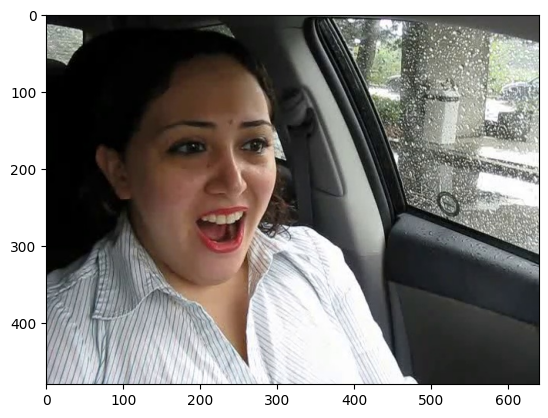

In [7]:
#yawn
plt.imshow(plt.imread("C:/Users/Safa/Desktop/PFE_2023/sleep_detection/train/yawn/104.jpg"))

In [8]:
# Load the Haar Cascade classifier for face detection

face_cascade = cv2.CascadeClassifier('C:/Users/Safa/Desktop/PFE_2023/sleep_detection/haarcascade_frontalface_default.xml')


In [9]:
face_cascade 

< cv2.CascadeClassifier 0000027254B84270>

# for yawn and not_yawn. Take only face

In [10]:
def face_for_yawn(direc="C:/Users/Safa/Desktop/PFE_2023/sleep_detection/train", face_cas_path="C:/Users/Safa/Desktop/PFE_2023/sleep_detection/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


# for closed and open eye¶


In [11]:
def open_closed_eye(dir_path="C:/Users/Safa/Desktop/PFE_2023/sleep_detection/train/", face_cas="C:/Users/Safa/Desktop/PFE_2023/sleep_detection/haarcascade_frontalface_default.xml", eye_cas="C:/Users/Safa/Desktop/PFE_2023/sleep_detection/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [12]:
data_train = open_closed_eye()

2
3


# Extend data 

In [13]:
def extend_data():
    d1  =  face_for_yawn()
    d2  =  open_closed_eye()
    d1.extend(d2)
    return d1

In [14]:
data = extend_data()

0
1
2
3


In [15]:
len(data)

1925

In [16]:
import random
random.shuffle(data) # shuffling data for ignoring the biasness while training

# separate label and features

In [17]:
x = list()
y = list()

for features, label in data:
    x.append(features)
    y.append(label)

# Converting x and y in array form

In [18]:
x = np.array(x)
y = np.array(y)

In [19]:
len(x)

1925

In [20]:
len(y)

1925

In [21]:
x.shape


(1925, 145, 145, 3)

In [22]:
y.shape

(1925,)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [25]:
x_train.shape

(1443, 145, 145, 3)

In [26]:
x_test.shape

(482, 145, 145, 3)

# Perform Data Augmentation to make more data from existing data¶


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(x_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(x_test), y_test, shuffle=False)

In [29]:
n_classes = 4

models = models.Sequential([
    #STEP--1 Convolutio
    # STEP--2 MAX Pooling
    layers.Conv2D(256, (3, 3), activation="relu", input_shape = x_train.shape[1:]),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),

    # STEP--3 FLattening
    layers.Flatten(),
    layers.Dropout(0.5),
    
    # STEP--4 Fully Connected Neural Network
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

In [30]:
models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [31]:
# Compiling the CNN in keras

models.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [32]:
# Starting the model training

EPOCHS = 10 # replace 10 with the number of epochs you want to use
history = models.fit(
    train_generator,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    validation_data=test_generator
)



Epoch 1/10
46/46 [==============================] - 381s 6s/step - loss: 1.1358 - accuracy: 0.5087 - val_loss: 0.5666 - val_accuracy: 0.7386
Epoch 2/10
46/46 [==============================] - 175s 4s/step - loss: 0.4859 - accuracy: 0.7921 - val_loss: 0.3295 - val_accuracy: 0.8714
Epoch 3/10
46/46 [==============================] - 167s 4s/step - loss: 0.3714 - accuracy: 0.8427 - val_loss: 0.2324 - val_accuracy: 0.9108
Epoch 4/10
46/46 [==============================] - 169s 4s/step - loss: 0.3228 - accuracy: 0.8586 - val_loss: 0.2318 - val_accuracy: 0.9046
Epoch 5/10
46/46 [==============================] - 177s 4s/step - loss: 0.2955 - accuracy: 0.8808 - val_loss: 0.1976 - val_accuracy: 0.9191
Epoch 6/10
46/46 [==============================] - 261s 6s/step - loss: 0.2631 - accuracy: 0.8863 - val_loss: 0.1767 - val_accuracy: 0.9357
Epoch 7/10
46/46 [==============================] - 207s 4s/step - loss: 0.2501 - accuracy: 0.8870 - val_loss: 0.2724 - val_accuracy: 0.8859
Epoch 8/10
46

In [33]:
#evaluating the performance of a trained Keras model on a test dataset provided by test_generator.
scores = models.evaluate(test_generator)
loss, accuracy = scores

16/16 [==============================] - 14s 705ms/step - loss: 0.1588 - accuracy: 0.9336


In [34]:
print("Accuracy of model is : ",accuracy*100)
print("Loss of model is : ",loss*100)

Accuracy of model is :  93.36099624633789
Loss of model is :  15.879988670349121


# Testing the CNN classifier on unseen images

In [35]:
models.save("drowiness_new6.h5")

In [36]:
models.save("drowiness_new6.model")

INFO:tensorflow:Assets written to: drowiness_new6.model\assets


INFO:tensorflow:Assets written to: drowiness_new6.model\assets


In [37]:
from tensorflow.keras.models import load_model
import cv2
from PIL import Image
from keras.preprocessing import image
import numpy as np

In [38]:
model_path = 'C:/Users/Safa/Desktop/PFE_2023/sleep_detection/drowiness_new6.h5'
model = load_model(model_path)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

# Prediction

In [40]:
predict_x=model.predict(x_test) 
classes_x=np.argmax(predict_x,axis=1)

16/16 [==============================] - 11s 565ms/step


In [41]:
prediction = classes_x
prediction

array([2, 1, 2, 2, 3, 3, 2, 0, 3, 2, 1, 3, 3, 3, 1, 1, 2, 3, 0, 3, 3, 3,
       1, 2, 2, 3, 1, 0, 2, 1, 1, 2, 2, 2, 3, 2, 1, 2, 2, 2, 0, 3, 3, 3,
       2, 1, 2, 3, 2, 2, 1, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 1, 3, 1, 0,
       1, 2, 2, 2, 1, 1, 1, 3, 1, 2, 2, 3, 2, 3, 3, 1, 1, 1, 1, 2, 2, 3,
       1, 2, 3, 2, 3, 3, 2, 3, 3, 3, 0, 1, 2, 2, 1, 2, 2, 2, 3, 3, 3, 2,
       2, 0, 1, 3, 1, 2, 2, 3, 2, 2, 2, 2, 3, 3, 0, 2, 3, 1, 1, 3, 2, 2,
       2, 0, 3, 3, 2, 1, 3, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1, 0, 3, 3,
       3, 3, 3, 2, 1, 1, 2, 2, 2, 2, 3, 3, 1, 2, 3, 3, 2, 2, 1, 3, 2, 1,
       2, 3, 0, 1, 3, 3, 2, 2, 1, 3, 1, 3, 3, 2, 3, 3, 3, 2, 3, 1, 1, 3,
       1, 3, 2, 1, 2, 3, 3, 3, 0, 3, 2, 2, 3, 2, 1, 1, 3, 2, 0, 1, 1, 0,
       2, 2, 0, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 1, 0, 2, 2, 2, 3, 2,
       2, 2, 3, 3, 2, 1, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2, 1, 3, 1, 1, 2, 3,
       3, 2, 3, 2, 1, 2, 2, 2, 2, 3, 3, 2, 2, 1, 0, 3, 3, 2, 1, 2, 2, 3,
       2, 0, 2, 2, 2, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3,